In [6]:
import sys
sys.path.append('../')
path_data = '/home/jaime/projects/Dropbox_project/projects/kaggle/Housing_prices_course/data/'

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
def type_and_nulls(df):
    df_type = pd.concat([pd.DataFrame(df.dtypes), df.isnull().sum().to_frame().rename(columns={0:'nulls'})], axis=1)
    display(df_type.head())
    display(df.dtypes.value_counts())
    not_nulls = list((df_type[df_type['nulls']==0]).index)
    nulls = list((df_type[df_type['nulls']>0]).index)
    
    dict_type_columns = {}
    for type_column in list(df.dtypes.value_counts().index):
        dict_type_columns[str(type_column)] = list(df_type[df_type[0] == type_column].index)
    
    print('Nulls features: ', len(nulls))
    print('Not null features: ', len(not_nulls))
    
    dict_type_columns['nulls'] = nulls
    dict_type_columns['not_nulls'] = not_nulls
    
    
    return dict_type_columns, df_type


def correlation_heatmap(df, columns, figsize=(12, 9), plot=False):
    corrmat = df[columns].corr()
    sorted_columns = corrmat.sum(axis=1).sort_values().index.values
    corrmat = corrmat.loc[sorted_columns][sorted_columns]
    if plot:
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corrmat, vmax=.8, square=True)
    return corrmat

def polynomial_transformations(df_train, columns, degree=2, scale_method=None):
    if scale_method is not None:
        df_train, df_val = apply_scale(df_train[columns], df_val[columns], scale_method)
    poly_trans = PolynomialFeatures(degree=degree)
    df_result_train = pd.DataFrame(poly_trans.fit_transform(df_train[columns]))
        
    df_result_train.columns = poly_trans.get_feature_names_out()
    
    return df_result_train

def select_complex_features(x_train_local, y_train_local, x_val_local, y_val_local, target):
    
    list_metrics = [] 
    
    corr_target = correlation_heatmap(pd.concat([x_train_local, pd.DataFrame(y_train_local)], axis=1), 
                                      pd.concat([x_train_local, pd.DataFrame(y_train_local)], axis=1).columns)
    
    for num_best_features in np.arange(1, x_train_local.shape[1]+1, 1):
        
        high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_best_features+1].index)        
                
        df_polyn_train =  polynomial_transformations(x_train_local, high_corr_features_exp_1, degree=2)
        df_polyn_val =  polynomial_transformations(x_val_local, high_corr_features_exp_1, degree=2)


        lr = LinearRegression().fit(df_polyn_train.values, y_train_local.values)

        y_predict_train = lr.predict(df_polyn_train.values)
        y_predict_val = lr.predict(df_polyn_val.values)

        metric_train_pol = mean_squared_error(y_predict_train, y_train_local.values)
        metric_val_pol = mean_squared_error(y_predict_val, y_val_local.values)   

        list_metrics.append([num_best_features, metric_val_pol]) 
        
#         print(num_best_features, corr_target.shape)
#         print(high_corr_features_exp_1)
#         print(metric_val_pol)
#         print()
        
    min_index = np.argmin(np.array(list_metrics)[:, 1], 0)
    return list_metrics[min_index][0]
    

In [9]:
df_train = pd.read_csv(path_data+'train.csv', index_col='Id')
df_test = pd.read_csv(path_data+'test.csv', index_col='Id')

In [10]:
dict_type_columns, df_type = type_and_nulls(df_train)

,0,nulls
MSSubClass,int64,0
MSZoning,object,0
LotFrontage,float64,259
LotArea,int64,0
Street,object,0


object     43
int64      34
float64     3
dtype: int64

Nulls features:  19
Not null features:  61


In [11]:
dict_type_columns.keys()

dict_keys(['object', 'int64', 'float64', 'nulls', 'not_nulls'])

In [12]:
numerical_features_not_null = set(dict_type_columns['int64'] + dict_type_columns['float64']) - set(dict_type_columns['nulls'])
numerical_features_not_null = list(numerical_features_not_null)
target = numerical_features_not_null.pop(numerical_features_not_null.index('SalePrice'))
len(numerical_features_not_null)
print(target)
print(len(numerical_features_not_null), numerical_features_not_null)

SalePrice
33 ['WoodDeckSF', 'YearRemodAdd', 'OverallCond', 'YrSold', 'BsmtUnfSF', '3SsnPorch', 'OverallQual', 'GarageArea', 'BsmtFullBath', 'BsmtFinSF1', 'MSSubClass', 'LotArea', 'LowQualFinSF', 'PoolArea', 'YearBuilt', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtHalfBath', 'HalfBath', 'MoSold', 'Fireplaces', 'BedroomAbvGr', 'ScreenPorch', 'MiscVal', '2ndFlrSF', 'EnclosedPorch', 'FullBath', 'KitchenAbvGr', 'GrLivArea', 'TotRmsAbvGrd', '1stFlrSF', 'OpenPorchSF']


In [13]:
df_train[numerical_features_not_null].describe()

,WoodDeckSF,YearRemodAdd,OverallCond,YrSold,BsmtUnfSF,3SsnPorch,OverallQual,GarageArea,BsmtFullBath,BsmtFinSF1,...,ScreenPorch,MiscVal,2ndFlrSF,EnclosedPorch,FullBath,KitchenAbvGr,GrLivArea,TotRmsAbvGrd,1stFlrSF,OpenPorchSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,94.244521,1984.865753,5.575342,2007.815753,567.240411,3.409589,6.099315,472.980137,0.425342,443.639726,...,15.060959,43.489041,346.992466,21.954110,1.565068,1.046575,1515.463699,6.517808,1162.626712,46.660274
std,125.338794,20.645407,1.112799,1.328095,441.866955,29.317331,1.382997,213.804841,0.518911,456.098091,...,55.757415,496.123024,436.528436,61.119149,0.550916,0.220338,525.480383,1.625393,386.587738,66.256028
min,0.000000,1950.000000,1.000000,2006.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,2.000000,334.000000,0.000000
25%,0.000000,1967.000000,5.000000,2007.000000,223.000000,0.000000,5.000000,334.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1129.500000,5.000000,882.000000,0.000000
50%,0.000000,1994.000000,5.000000,2008.000000,477.500000,0.000000,6.000000,480.000000,0.000000,383.500000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1464.000000,6.000000,1087.000000,25.000000
75%,168.000000,2004.000000,6.000000,2009.000000,808.000000,0.000000,7.000000,576.000000,1.000000,712.250000,...,0.000000,0.000000,728.000000,0.000000,2.000000,1.000000,1776.750000,7.000000,1391.250000,68.000000
max,857.000000,2010.000000,9.000000,2010.000000,2336.000000,508.000000,10.000000,1418.000000,3.000000,5644.000000,...,480.000000,15500.000000,2065.000000,552.000000,3.000000,3.000000,5642.000000,14.000000,4692.000000,547.000000


In [33]:
def train_final_model(alpha_est):
    
    lr = Ridge(alpha=alpha_est).fit(X_train.values, Y_train.values)

    y_predict_train = lr.predict(X_train.values)
    y_predict_test = lr.predict(X_test.values)

    metric_train = mean_squared_error(y_predict_train, Y_train.values)
    metric_test = mean_squared_error(y_predict_test, Y_test.values)   
    
    return metric_train, metric_test
    
def train_val_estimate_alpha(x_train, y_train, x_val, y_val):
    list_estimation = []
    for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
            
        lr = Ridge(alpha=alpha).fit(x_train.values, y_train.values)

        y_predict_train = lr.predict(x_train.values)
        y_predict_val = lr.predict(x_val.values)

        metric_train = mean_squared_error(y_predict_train, y_train.values)
        metric_val = mean_squared_error(y_predict_val, y_val.values) 

        list_estimation.append([alpha, metric_train, metric_val])
        
    df_metric_exp_1 = pd.DataFrame(list_estimation)
    df_metric_exp_1.columns = ['alpha', 'metric_train', 'metric_val']
    return df_metric_exp_1.sort_values('metric_val').iloc[0,:]    

def cross_validation_estimate_alpha():
    
    list_estimation = []
    for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        list_estimation_tmp = []
        kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)
        for fold, (index_train, index_val) in enumerate(kf.split(X_train)):
            #print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)  

            lr = Ridge(alpha=alpha).fit(X_train.iloc[index_train].values, Y_train.iloc[index_train].values)

            y_predict_train = lr.predict(X_train.iloc[index_train].values)
            y_predict_val = lr.predict(X_train.iloc[index_val].values)

            metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
            metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

            list_estimation_tmp.append([metric_train, metric_val])
#             print(alpha, metric_train, metric_val)        
            
        metric_train, metric_val = np.mean(list_estimation_tmp, axis=0)
        list_estimation.append([alpha, metric_train, metric_val])
    
    df_metric_exp_1 = pd.DataFrame(list_estimation)
    df_metric_exp_1.columns = ['alpha', 'metric_train', 'metric_val']
    return df_metric_exp_1.sort_values('metric_val').iloc[0,:]    

def bar_plots(column_x, column_y, df_x, df_y=None, figsize=(15,5)):
    plt.figure(figsize=figsize)
    if df_y is None:
        if type(column_x) is list:
            sns.barplot(df_x[column_x[0]], df_x[column_y], df_x[column_x[1]])
        else:
            sns.barplot(x=df_x[column_x], y=df_x[column_y])
        
    else:
        if type(column_x) is list:
            sns.barplot(df_x[column_x[0]], df_y[column_y], df_x[column_x[1]])
        else:
            sns.barplot(x=df_x[column_x], y=df_y[column_y])

## 0 train/val/test or cross-validation


In [15]:
target = 'SalePrice'
## experiment parameters 
K_folds = 5
results_experiments = {}

In [34]:
## Split training and test datasets. train/test proportion 80/20
list_results_train_val = []
list_results_cv = []
for p_test in [0.1, 0.2, 0.3, 0.4, 0.5]:
    
    X_train, X_test = train_test_split(df_train[numerical_features_not_null+[target]], 
                                       test_size=p_test, random_state=0)
    Y_train = X_train.pop(target)
    Y_test = X_test.pop(target)
    
    print('size train/test ', p_test)
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)    

    ## feature scale
    scaler = StandardScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
    X_train.columns = numerical_features_not_null

    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
    X_test.columns = numerical_features_not_null   
    
    for p_val in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
        ## train/val split 70/30
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=p_val, random_state=0)
        print('size train/val ', p_test)
        print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
        
        best_alpha = train_val_estimate_alpha(x_train, y_train, x_val, y_val)        
        best_alpha = best_alpha.to_dict()
        ## Train a final model
        metric_train, metric_test = train_final_model(best_alpha['alpha'])
        best_alpha['all_train'] = metric_train
        best_alpha['test'] = metric_test
        best_alpha['p_test'] = p_test
        best_alpha['p_val'] = p_val        
        list_results_train_val.append(best_alpha)
    
    best_alpha_cv = cross_validation_estimate_alpha()
    best_alpha_cv = best_alpha_cv.to_dict()
    metric_train, metric_test = train_final_model(best_alpha_cv['alpha'])
    best_alpha_cv['all_train'] = metric_train
    best_alpha_cv['test'] = metric_test        
    best_alpha_cv['p_test'] = p_test
    list_results_cv.append(best_alpha_cv)
    

size train/test  0.1
(1314, 33) (1314,) (146, 33) (146,)
size train/val  0.1
(1182, 33) (1182,) (132, 33) (132,)
size train/val  0.1
(1051, 33) (1051,) (263, 33) (263,)
size train/val  0.1
(919, 33) (919,) (395, 33) (395,)
size train/val  0.1
(788, 33) (788,) (526, 33) (526,)
size train/val  0.1
(657, 33) (657,) (657, 33) (657,)
size train/test  0.2
(1168, 33) (1168,) (292, 33) (292,)
size train/val  0.2
(1051, 33) (1051,) (117, 33) (117,)
size train/val  0.2
(934, 33) (934,) (234, 33) (234,)
size train/val  0.2
(817, 33) (817,) (351, 33) (351,)
size train/val  0.2
(700, 33) (700,) (468, 33) (468,)
size train/val  0.2
(584, 33) (584,) (584, 33) (584,)
size train/test  0.3
(1022, 33) (1022,) (438, 33) (438,)
size train/val  0.3
(919, 33) (919,) (103, 33) (103,)
size train/val  0.3
(817, 33) (817,) (205, 33) (205,)
size train/val  0.3
(715, 33) (715,) (307, 33) (307,)
size train/val  0.3
(613, 33) (613,) (409, 33) (409,)
size train/val  0.3
(511, 33) (511,) (511, 33) (511,)
size train/te

In [35]:
pd.DataFrame(list_results_train_val)

,alpha,metric_train,metric_val,all_train,test,p_test,p_val
0,0.000,1.164822e+09,1.369373e+09,1.181082e+09,1.578204e+09,0.1,0.1
1,128.000,1.130557e+09,1.493031e+09,1.194547e+09,1.579062e+09,0.1,0.2
2,1024.000,1.181208e+09,1.925256e+09,1.360572e+09,1.712498e+09,0.1,0.3
3,1024.000,1.296069e+09,1.627166e+09,1.360572e+09,1.712498e+09,0.1,0.4
4,512.000,1.225633e+09,1.429732e+09,1.265518e+09,1.622407e+09,0.1,0.5
5,0.001,9.656938e+08,1.024365e+09,9.696771e+08,2.460924e+09,0.2,0.1
6,8.000,1.009091e+09,8.378931e+08,9.697791e+08,2.453215e+09,0.2,0.2
7,0.000,9.470328e+08,1.095579e+09,9.687459e+08,2.428791e+09,0.2,0.3
8,0.000,9.445841e+08,1.073557e+09,9.687459e+08,2.428791e+09,0.2,0.4
9,4.000,9.758453e+08,1.058721e+09,9.697032e+08,2.456996e+09,0.2,0.5


In [45]:
pd.DataFrame(list_results_cv)

,alpha,metric_train,metric_val,all_train,test,p_test
0,128.0,1.178155e+09,1.393060e+09,1.194547e+09,1.579062e+09,0.1
1,64.0,9.654170e+08,1.076473e+09,9.744634e+08,2.411596e+09,0.2
2,64.0,9.927309e+08,1.122453e+09,1.004081e+09,1.837678e+09,0.3
3,64.0,1.053705e+09,1.187315e+09,1.063708e+09,1.540955e+09,0.4
4,64.0,8.261251e+08,1.006603e+09,8.382988e+08,1.754700e+09,0.5


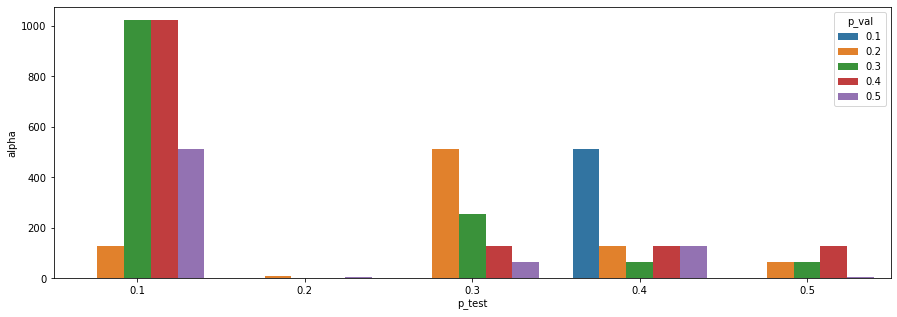

In [39]:
# bar_plots(column_x, column_y, pd.DataFrame(list_results_train_val), df_y=None, figsize=(15,5))

# general_eda.bar_plots(['OverallQual', 'LotShape'], 'SalePrice', df_train)

bar_plots(['p_test', 'p_val'], 'alpha', pd.DataFrame(list_results_train_val))

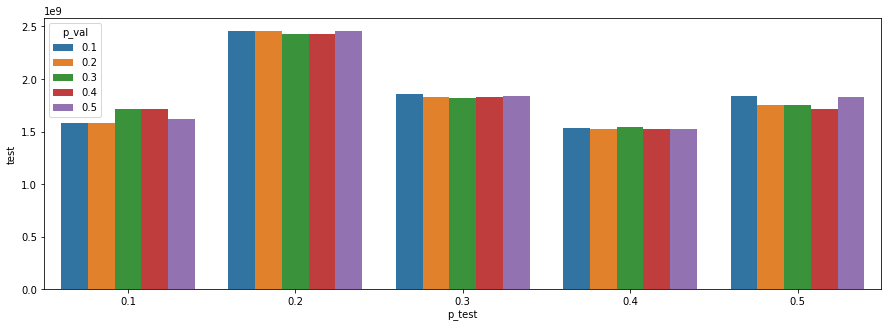

In [44]:
bar_plots(['p_test', 'p_val'], 'test', pd.DataFrame(list_results_train_val))

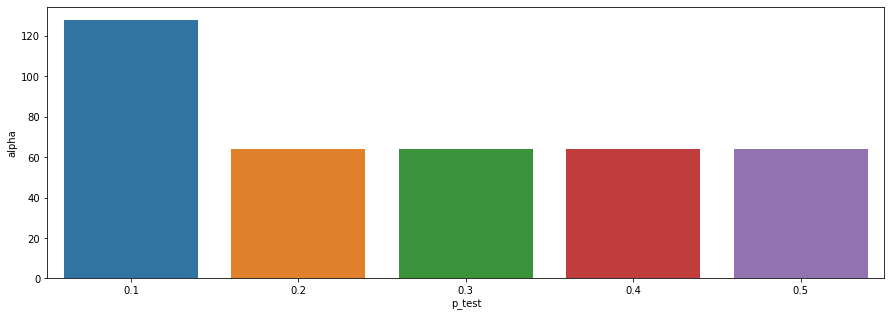

In [41]:
bar_plots('p_test', 'alpha', pd.DataFrame(list_results_cv))

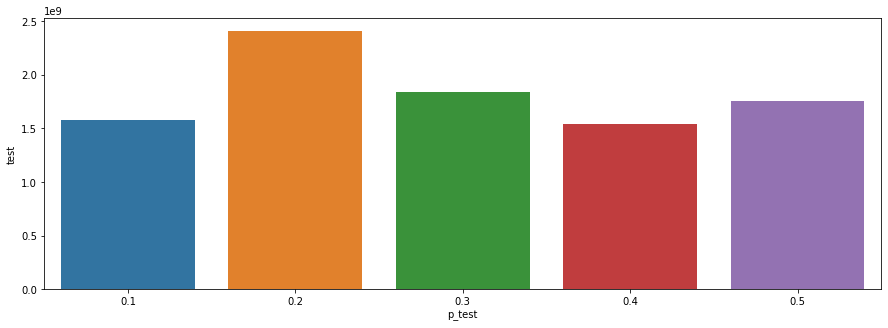

In [42]:
bar_plots('p_test', 'test', pd.DataFrame(list_results_cv))

In [97]:
## Split training and test datasets. train/test proportion 80/20

target = 'SalePrice'

X_train, X_test = train_test_split(df_train[numerical_features_not_null+[target]], test_size=0.1, random_state=0)
Y_train = X_train.pop(target)
Y_test = X_test.pop(target)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1314, 33), (1314,), (146, 33), (146,))

In [98]:
## feature scale

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train.columns = numerical_features_not_null

X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test.columns = numerical_features_not_null   

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1314, 33), (1314,), (146, 33), (146,))

In [99]:
## experiment parameters 
K_folds = 5
results_experiments = {}

## 1. original features

### 1.1  using train/val partition

In [100]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1051, 33), (1051,), (263, 33), (263,))

In [101]:
## Estimate alpha
list_estimation = []
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    # lr = LinearRegression().fit(df_polyn_train.values, Y_train.values)
    lr = Ridge(alpha=alpha).fit(x_train.values, y_train.values)

    y_predict_train = lr.predict(x_train.values)
    y_predict_val = lr.predict(x_val.values)

    metric_train = mean_squared_error(y_predict_train, y_train.values)
    metric_val = mean_squared_error(y_predict_val, y_val.values) 
    
    list_estimation.append([alpha, metric_train, metric_val])


In [104]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metric.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
13,128.000,1.130557e+09,1.493031e+09
12,64.000,1.116578e+09,1.497880e+09
14,256.000,1.163045e+09,1.502834e+09
11,32.000,1.111466e+09,1.505752e+09
10,16.000,1.109835e+09,1.512043e+09
9,8.000,1.109365e+09,1.516019e+09
8,4.000,1.109238e+09,1.518261e+09
7,2.000,1.109204e+09,1.519452e+09
6,1.000,1.109196e+09,1.520067e+09
5,0.800,1.109195e+09,1.520191e+09


In [105]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)

lr = Ridge(alpha=best_alpha).fit(X_train.values, Y_train.values)

y_predict_train = lr.predict(X_train.values)
y_predict_test = lr.predict(X_test.values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)
results_experiments['or_features_train_val'] = [metric_train.copy(), metric_test.copy()]

128.0
1194547059.341902 1579061928.6862667


In [106]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09


### 1.1  using 5-fold cv

In [107]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

In [108]:
list_estimation = []
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    list_estimation_tmp = []
    for fold, (index_train, index_val) in enumerate(kf.split(X_train)):
        #print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)  
                
        lr = Ridge(alpha=alpha).fit(X_train.iloc[index_train].values, Y_train.iloc[index_train].values)

        y_predict_train = lr.predict(X_train.iloc[index_train].values)
        y_predict_val = lr.predict(X_train.iloc[index_val].values)

        metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
        metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

        list_estimation_tmp.append([metric_train, metric_val])
        #print(alpha, metric_train, metric_val)        

    #print('metric train/test: ', np.mean(list_estimation_tmp, axis=0))
    
    metric_train, metric_val = np.mean(list_estimation_tmp, axis=0)
    list_estimation.append([alpha, metric_train, metric_val])

In [109]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metrics.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
13,128.000,1.178155e+09,1.393060e+09
12,64.000,1.165116e+09,1.397979e+09
14,256.000,1.208628e+09,1.399360e+09
11,32.000,1.160376e+09,1.405219e+09
10,16.000,1.158874e+09,1.410957e+09
9,8.000,1.158443e+09,1.414579e+09
8,4.000,1.158327e+09,1.416620e+09
7,2.000,1.158297e+09,1.417704e+09
6,1.000,1.158289e+09,1.418264e+09
5,0.800,1.158288e+09,1.418377e+09


In [110]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)
lr = Ridge(alpha=best_alpha).fit(X_train.values, Y_train.values)

y_predict_train = lr.predict(X_train.values)
y_predict_test = lr.predict(X_test.values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)
results_experiments['or_features_cv'] = [metric_train.copy(), metric_test.copy()]

128.0
1194547059.341902 1579061928.6862667


In [111]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09
or_features_cv,1.194547e+09,1.579062e+09


## 2. polynomial features

### 2.1  using train/val partition

In [112]:
num_features = 10
columns = list(X_train.columns)+[target]
corr_target = correlation_heatmap(pd.concat([X_train, pd.DataFrame(Y_train)], axis=1), 
                                 columns)
high_corr_features = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)        
high_corr_features, len(high_corr_features)

(['OverallQual',
  'GrLivArea',
  'GarageCars',
  'GarageArea',
  'TotalBsmtSF',
  '1stFlrSF',
  'FullBath',
  'TotRmsAbvGrd',
  'YearBuilt',
  'YearRemodAdd'],
 10)

In [113]:
## Estimate alpha
list_estimation = []
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    
    df_polyn_train =  polynomial_transformations(x_train, high_corr_features, degree=2)
    df_polyn_val =  polynomial_transformations(x_val, high_corr_features, degree=2)

    
    lr = Ridge(alpha=alpha).fit(df_polyn_train.values, y_train.values)
    
    y_predict_train = lr.predict(df_polyn_train.values)
    y_predict_val = lr.predict(df_polyn_val.values)
    
    metric_train = mean_squared_error(y_predict_train, y_train.values)
    metric_val = mean_squared_error(y_predict_val, y_val.values) 
    
    list_estimation.append([alpha, metric_train, metric_val])


In [114]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metrics.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
15,512.000,8.625575e+08,1.824926e+09
14,256.000,7.799737e+08,1.829192e+09
13,128.000,7.312834e+08,1.849073e+09
16,1024.000,1.011286e+09,1.865275e+09
12,64.000,7.031168e+08,1.879112e+09
11,32.000,6.877518e+08,1.914776e+09
10,16.000,6.800214e+08,1.948848e+09
9,8.000,6.765389e+08,1.975688e+09
8,4.000,6.751750e+08,1.993824e+09
7,2.000,6.747129e+08,2.004762e+09


In [115]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)

df_polyn_train =  polynomial_transformations(X_train, high_corr_features, degree=2)
df_polyn_test =  polynomial_transformations(X_test, high_corr_features, degree=2)

lr = Ridge(alpha=best_alpha).fit(df_polyn_train.values, Y_train.values)

y_predict_train = lr.predict(df_polyn_train.values)
y_predict_test = lr.predict(df_polyn_test.values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)
results_experiments['poly_features_train_val'] = [metric_train.copy(), metric_test.copy()]

512.0
977909424.518743 999893898.2810724


In [116]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09
or_features_cv,1.194547e+09,1.579062e+09
poly_features_train_val,9.779094e+08,9.998939e+08


### 2.2  using 5-cv

In [117]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

In [118]:
list_estimation = []
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    list_estimation_tmp = []
    for fold, (index_train, index_val) in enumerate(kf.split(X_train)):
        #print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)  

        df_polyn_train =  polynomial_transformations(X_train.iloc[index_train], high_corr_features, degree=2)
        df_polyn_val =  polynomial_transformations(X_train.iloc[index_val], high_corr_features, degree=2)
        
        lr = Ridge(alpha=alpha).fit(df_polyn_train.values, Y_train.iloc[index_train].values)

        y_predict_train = lr.predict(df_polyn_train.values)
        y_predict_val = lr.predict(df_polyn_val.values )

        metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
        metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

        list_estimation_tmp.append([metric_train, metric_val])        

    #print('metric train/test: ', np.mean(list_metrics_exp_1, axis=0))
    #print('std train/test: ', np.std(list_metrics_exp_1, axis=0))
    
    metric_train, metric_val = np.mean(list_estimation_tmp, axis=0)
    list_estimation.append([alpha, metric_train, metric_val])        

In [119]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metrics.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
13,128.000,8.519072e+08,1.127000e+09
12,64.000,8.214447e+08,1.141058e+09
14,256.000,9.033723e+08,1.187496e+09
11,32.000,8.042134e+08,1.201141e+09
10,16.000,7.948053e+08,1.272569e+09
15,512.000,9.880611e+08,1.331749e+09
9,8.000,7.900116e+08,1.334621e+09
8,4.000,7.878834e+08,1.380606e+09
7,2.000,7.870878e+08,1.410868e+09
6,1.000,7.868325e+08,1.428890e+09


In [120]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)

df_polyn_train =  polynomial_transformations(X_train, high_corr_features, degree=2)
df_polyn_test =  polynomial_transformations(X_test, high_corr_features, degree=2)

lr = Ridge(alpha=best_alpha).fit(df_polyn_train.values, Y_train.values)

y_predict_train = lr.predict(df_polyn_train.values)
y_predict_test = lr.predict(df_polyn_test.values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)
results_experiments['poly_features_cv'] = [metric_train.copy(), metric_test.copy()]

128.0
867746947.6857089 937050590.9702797


In [121]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09
or_features_cv,1.194547e+09,1.579062e+09
poly_features_train_val,9.779094e+08,9.998939e+08
poly_features_cv,8.677469e+08,9.370506e+08


## 3. more polynomial features 

In [122]:
num_features = 100

In [123]:
X_train.shape

(1314, 33)

In [124]:
X_train_pol =  polynomial_transformations(X_train, X_train.columns, degree=2)
X_train_pol.shape

(1314, 595)

### 3.1 cv with a set 100 features

In [129]:
columns = list(X_train_pol.columns)+[target]
corr_target = correlation_heatmap(pd.concat([X_train_pol, pd.DataFrame(Y_train)], axis=1), columns)
high_corr_features = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)        
len(high_corr_features)

100

In [130]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

In [131]:
list_estimation = []
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    list_estimation_tmp = []
    for fold, (index_train, index_val) in enumerate(kf.split(X_train_pol)):
        #print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)  
                
        lr = Ridge(alpha=alpha).fit(X_train_pol[high_corr_features].iloc[index_train].values, 
                                    Y_train.iloc[index_train].values)

        y_predict_train = lr.predict(X_train_pol[high_corr_features].iloc[index_train].values)
        y_predict_val = lr.predict(X_train_pol[high_corr_features].iloc[index_val].values)

        metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
        metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

        list_estimation_tmp.append([metric_train, metric_val])        

    #print('metric train/test: ', np.mean(list_metrics_exp_1, axis=0))
    #print('std train/test: ', np.std(list_metrics_exp_1, axis=0))
    
    metric_train, metric_val = np.mean(list_estimation_tmp, axis=0)
    list_estimation.append([alpha, metric_train, metric_val])        

In [132]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metrics.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
13,128.000,2.439667e+09,3.998658e+09
14,256.000,2.606269e+09,4.366815e+09
15,512.000,2.851945e+09,5.367176e+09
16,1024.000,3.206703e+09,6.317446e+09
12,64.000,2.311162e+09,6.397004e+09
11,32.000,2.182926e+09,1.867172e+10
10,16.000,2.027382e+09,6.263602e+10
9,8.000,1.835695e+09,1.926241e+11
8,4.000,1.630066e+09,5.029036e+11
7,2.000,1.455988e+09,1.084410e+12


In [133]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)

lr = Ridge(alpha=best_alpha).fit(X_train_pol[high_corr_features].values, Y_train.values)

y_predict_train = lr.predict(X_train_pol[high_corr_features])

X_test_poly =  polynomial_transformations(X_test, X_test.columns, degree=2)
y_predict_test = lr.predict(X_test_poly[high_corr_features].values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)
results_experiments['correct_cv_app_1'] = [metric_train.copy(), metric_test.copy()]

128.0
2514233380.796661 13278297714.804464


In [134]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09
or_features_cv,1.194547e+09,1.579062e+09
poly_features_train_val,9.779094e+08,9.998939e+08
poly_features_cv,8.677469e+08,9.370506e+08
correct_cv_app_1,2.514233e+09,1.327830e+10


### 3.2 100 best features for each fold

In [135]:
num_features = 100
columns = list(X_train_pol.columns)+[target]

In [136]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

In [137]:
list_estimation = []
dict_features_fold = {}
i = 0
for alpha in [0, 0.001, 0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    list_estimation_tmp = []
    for fold, (index_train, index_val) in enumerate(kf.split(X_train_pol)):
        print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)                  
        
        if i == 0:
        
            corr_target = correlation_heatmap(pd.concat([X_train_pol.iloc[index_train], 
                                                         Y_train.iloc[index_train]], axis=1), columns)
            high_corr_features = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)
        
            dict_features_fold[fold] = high_corr_features
            
        else:
            high_corr_features = dict_features_fold[fold]
        
        lr = Ridge(alpha=alpha).fit(X_train_pol.iloc[index_train][high_corr_features].values, 
                                    Y_train.iloc[index_train].values)

        y_predict_train = lr.predict(X_train_pol.iloc[index_train][high_corr_features].values)
        y_predict_val = lr.predict(X_train_pol.iloc[index_val][high_corr_features].values)

        metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
        metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

        list_estimation_tmp.append([metric_train, metric_val])
        
        print(pd.DataFrame(high_corr_features).sort_values(0))
        
    metric_train, metric_val = np.mean(list_estimation_tmp, axis=0)
    list_estimation.append([alpha, metric_train, metric_val])          
     
    i += 1

0 idx_train:  (1051,)  idx_val: (263,)
                           0
57                1stFlrSF^2
80                  2ndFlrSF
93                2ndFlrSF^2
61              BedroomAbvGr
32       BsmtFinSF1 1stFlrSF
..                       ...
78  YearRemodAdd OpenPorchSF
83  YearRemodAdd TotalBsmtSF
27       YrSold BedroomAbvGr
88          YrSold GrLivArea
87       YrSold TotRmsAbvGrd

[100 rows x 1 columns]
1 idx_train:  (1051,)  idx_val: (263,)
                             0
93        1stFlrSF OpenPorchSF
14                  1stFlrSF^2
46       BedroomAbvGr 1stFlrSF
84  BedroomAbvGr EnclosedPorch
6          BsmtFinSF1 1stFlrSF
..                         ...
58           YrSold GarageArea
68           YrSold GarageCars
52            YrSold GrLivArea
83             YrSold HalfBath
75         YrSold TotRmsAbvGrd

[100 rows x 1 columns]
2 idx_train:  (1051,)  idx_val: (263,)
                         0
64              1stFlrSF^2
19               3SsnPorch
9       3SsnPorch 1stFlrSF
5     3

                             0
93        1stFlrSF OpenPorchSF
14                  1stFlrSF^2
46       BedroomAbvGr 1stFlrSF
84  BedroomAbvGr EnclosedPorch
6          BsmtFinSF1 1stFlrSF
..                         ...
58           YrSold GarageArea
68           YrSold GarageCars
52            YrSold GrLivArea
83             YrSold HalfBath
75         YrSold TotRmsAbvGrd

[100 rows x 1 columns]
2 idx_train:  (1051,)  idx_val: (263,)
                         0
64              1stFlrSF^2
19               3SsnPorch
9       3SsnPorch 1stFlrSF
5     3SsnPorch BsmtFinSF1
13  3SsnPorch BsmtFullBath
..                     ...
92         YrSold 1stFlrSF
41     YrSold BedroomAbvGr
90       YrSold GarageCars
80        YrSold GrLivArea
70     YrSold TotRmsAbvGrd

[100 rows x 1 columns]
3 idx_train:  (1051,)  idx_val: (263,)
                           0
17                1stFlrSF^2
8                  3SsnPorch
5         3SsnPorch 1stFlrSF
4       3SsnPorch BsmtFinSF1
13    3SsnPorch BsmtFullBath
..  

                         0
8                3SsnPorch
7       3SsnPorch 1stFlrSF
4     3SsnPorch BsmtFinSF1
28  3SsnPorch BsmtFullBath
24      3SsnPorch FullBath
..                     ...
72         YrSold FullBath
40       YrSold GarageArea
25       YrSold GarageCars
54        YrSold GrLivArea
42     YrSold TotRmsAbvGrd

[100 rows x 1 columns]
0 idx_train:  (1051,)  idx_val: (263,)
                           0
57                1stFlrSF^2
80                  2ndFlrSF
93                2ndFlrSF^2
61              BedroomAbvGr
32       BsmtFinSF1 1stFlrSF
..                       ...
78  YearRemodAdd OpenPorchSF
83  YearRemodAdd TotalBsmtSF
27       YrSold BedroomAbvGr
88          YrSold GrLivArea
87       YrSold TotRmsAbvGrd

[100 rows x 1 columns]
1 idx_train:  (1051,)  idx_val: (263,)
                             0
93        1stFlrSF OpenPorchSF
14                  1stFlrSF^2
46       BedroomAbvGr 1stFlrSF
84  BedroomAbvGr EnclosedPorch
6          BsmtFinSF1 1stFlrSF
..              

In [138]:
df_metrics = pd.DataFrame(list_estimation)
df_metrics.columns = ['alpha', 'metric_train', 'metric_val']
df_metrics = df_metrics.sort_values('metric_val')
df_metrics

,alpha,metric_train,metric_val
16,1024.000,3.226702e+09,6.433368e+09
15,512.000,2.863089e+09,6.487991e+09
14,256.000,2.607464e+09,6.536788e+09
13,128.000,2.431015e+09,6.919613e+09
12,64.000,2.296442e+09,8.343354e+09
11,32.000,2.171273e+09,1.234134e+10
10,16.000,2.034996e+09,2.194152e+10
9,8.000,1.886853e+09,4.136652e+10
8,4.000,1.747542e+09,7.317768e+10
7,2.000,1.641604e+09,1.157516e+11


In [139]:
pd.DataFrame(dict_features_fold).sort_values(0)

,0,1,2,3,4
57,1stFlrSF^2,OverallQual 1stFlrSF,HalfBath TotRmsAbvGrd,LotArea BsmtHalfBath,YrSold 3SsnPorch
80,2ndFlrSF,WoodDeckSF 3SsnPorch,YrSold GrLivArea,3SsnPorch FullBath,BsmtFullBath TotRmsAbvGrd
93,2ndFlrSF^2,1stFlrSF OpenPorchSF,LotArea BsmtHalfBath,YearRemodAdd OverallQual,GarageCars FullBath
61,BedroomAbvGr,GarageCars TotRmsAbvGrd,YearRemodAdd OpenPorchSF,OverallQual PoolArea,YearBuilt OpenPorchSF
32,BsmtFinSF1 1stFlrSF,TotalBsmtSF GrLivArea,GarageCars^2,BsmtFullBath GrLivArea,KitchenAbvGr OpenPorchSF
...,...,...,...,...,...
78,YearRemodAdd OpenPorchSF,LotArea OpenPorchSF,BsmtHalfBath FullBath,WoodDeckSF EnclosedPorch,BsmtFinSF1 GarageCars
83,YearRemodAdd TotalBsmtSF,YrSold HalfBath,GarageCars FullBath,OverallQual 1stFlrSF,OverallQual FullBath
27,YrSold BedroomAbvGr,PoolArea Fireplaces,HalfBath^2,HalfBath Fireplaces,EnclosedPorch GrLivArea
88,YrSold GrLivArea,LotArea TotRmsAbvGrd,YearRemodAdd Fireplaces,BsmtUnfSF BsmtFinSF1,YearRemodAdd LotArea


In [140]:
all_features = dict_features_fold[0] + dict_features_fold[1] + \
                dict_features_fold[2] + dict_features_fold[3] + dict_features_fold[4]

In [141]:
np.unique(all_features).shape

(224,)

In [142]:
X_test_poly =  polynomial_transformations(X_test, X_test.columns, degree=2)

In [143]:
## Train a final model
best_alpha = df_metrics.iloc[0]['alpha']
print(best_alpha)
list_predictions = []
for fold in dict_features_fold.keys():
    
    high_corr_features = dict_features_fold[fold]
    
    lr = Ridge(alpha=alpha).fit(X_train_pol[high_corr_features].values, Y_train.values)

    y_predict_train = lr.predict(X_train_pol[high_corr_features])    
    y_predict_test = lr.predict(X_test_poly[high_corr_features].values)

    metric_train = mean_squared_error(y_predict_train, Y_train.values)
    metric_test = mean_squared_error(y_predict_test, Y_test.values)   

    print(metric_train, metric_test)
    list_predictions.append([metric_train, metric_test])
    
results_experiments['correct_cv_app_2'] = list(np.mean(list_predictions, axis=0))

1024.0
2458000810.203523 6280058603.860518
2984871429.2772746 8171484334.783767
2947319576.144463 3325622876.467755
3654186197.054239 10608350019.031818
4142612169.9876776 4973678550.811479


In [144]:
df_results = pd.DataFrame(results_experiments).T
df_results.columns = ['train', 'test']
df_results

,train,test
or_features_train_val,1.194547e+09,1.579062e+09
or_features_cv,1.194547e+09,1.579062e+09
poly_features_train_val,9.779094e+08,9.998939e+08
poly_features_cv,8.677469e+08,9.370506e+08
correct_cv_app_1,2.514233e+09,1.327830e+10
correct_cv_app_2,3.237398e+09,6.671839e+09
